### Exploracion de datos de e-commerce sales log

- Importacion de librerias

In [ ]:
import pandas as pd    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
import plotly.graph_objects as go
from pylab import rcParams
sns.set_theme(style="ticks", palette="pastel")
import calplot

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [1]:
pd.reset_option("max_columns")
pd.set_option("max_colwidth",None)
pd.set_option('display.expand_frame_repr',False)
pd.set_option('display.max_columns',50)
pd.set_option('display.width',1000)

- Lectura de CSV

In [2]:
df= pd.read_csv('../data.csv',encoding='latin1')

- Frist look of the dataset

In [3]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


- Total amount of observations

In [4]:
print(len(df))

541909


- Top 10 products

In [5]:
df.groupby('Description').agg({'Quantity':'count'}).sort_values(by='Quantity',ascending=False).head(10)

,Quantity
Description,
WHITE HANGING HEART T-LIGHT HOLDER,2369
REGENCY CAKESTAND 3 TIER,2200
JUMBO BAG RED RETROSPOT,2159
PARTY BUNTING,1727
LUNCH BAG RED RETROSPOT,1638
ASSORTED COLOUR BIRD ORNAMENT,1501
SET OF 3 CAKE TINS PANTRY DESIGN,1473
PACK OF 72 RETROSPOT CAKE CASES,1385
LUNCH BAG BLACK SKULL.,1350


- Highest bill invoice note

In [6]:
df.groupby('InvoiceNo').agg({'UnitPrice':'sum'}).sort_values(by='UnitPrice',ascending=False).head(10)

,UnitPrice
InvoiceNo,
C556445,38970.00
C580605,17836.46
C540117,16888.02
C540118,16453.71
537632,13541.33
C537651,13541.33
C537630,13541.33
C537644,13474.79
C580604,11586.50


- Total sales per Country

In [7]:
df.groupby('Country').agg({'UnitPrice':'sum'}).sort_values(by='UnitPrice',ascending=False).head(10)

,UnitPrice
Country,
United Kingdom,2245715.474
EIRE,48447.190
France,43031.990
Germany,37666.000
Singapore,25108.890
Portugal,13037.540
Spain,12633.450
Hong Kong,12241.500
Belgium,7540.130


In [8]:
df_counts= df.groupby('Country').agg({'InvoiceNo':'count'}).sort_values(by='InvoiceNo',ascending=False)

- Top sales per date

In [9]:
df.groupby('InvoiceDate').agg({'Quantity':'count'}).sort_values(by='Quantity',ascending=False).head(10)

,Quantity
InvoiceDate,
10/31/2011 14:41,1114
12/8/2011 9:28,749
12/9/2011 10:03,731
12/5/2011 17:24,721
6/29/2011 15:58,705
11/30/2011 15:13,687
12/8/2011 9:20,676
12/6/2010 16:57,675
12/5/2011 17:28,662


- Visualization of nan values

In [10]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [11]:
no_nan_description=df[~df['Description'].isna()]

- Checking the patterns in the Customer ID column

In [12]:
no_nan_description.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133626
Country             0
dtype: int64

- Checking a specific value

In [13]:
no_nan_description[no_nan_description['InvoiceNo']=='536544'].tail(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1960,536544,21679,SKULLS STICKERS,3,12/1/2010 14:32,1.66,NaN,United Kingdom
1961,536544,21703,BAG 125g SWIRLY MARBLES,1,12/1/2010 14:32,0.85,NaN,United Kingdom
1962,536544,21704,BAG 250g SWIRLY MARBLES,1,12/1/2010 14:32,1.66,NaN,United Kingdom
1963,536544,21706,FOLDING UMBRELLA RED/WHITE POLKADOT,2,12/1/2010 14:32,10.17,NaN,United Kingdom
1964,536544,21716,BOYS VINTAGE TIN SEASIDE BUCKET,1,12/1/2010 14:32,5.06,NaN,United Kingdom
1965,536544,21721,CANDY SHOP STICKER SHEET,1,12/1/2010 14:32,1.66,NaN,United Kingdom
1966,536544,21722,SWEET PUDDING STICKER SHEET,1,12/1/2010 14:32,1.66,NaN,United Kingdom
1967,536544,21731,RED TOADSTOOL LED NIGHT LIGHT,5,12/1/2010 14:32,3.36,NaN,United Kingdom
1968,536544,21742,LARGE ROUND WICKER PLATTER,1,12/1/2010 14:32,12.72,NaN,United Kingdom
1969,536544,21758,VINTAGE SHELLS PRINT,1,12/1/2010 14:32,12.72,NaN,United Kingdom


In [14]:
no_id_nan= no_nan_description[~no_nan_description['CustomerID'].isna()]

- Lenght of loss regarding the elimination of NaN values

In [15]:
print(len(no_id_nan))
print(len(df))
print(len(df)-len(no_id_nan))

406829
541909
135080


- Tabular Visualization of the diference

In [16]:
no_id_nan_counts= no_id_nan.groupby('Country').agg({'InvoiceNo':'count'}).sort_values(by='InvoiceNo',ascending=False)

- Creating a view from the initial data vs the second tabular data to get the diference column

In [17]:
no_id_nan_counts = no_id_nan_counts.rename(columns={'InvoiceNo': 'no_id_nan_count'})
df_counts = df_counts.rename(columns={'InvoiceNo': 'df_count'})

comparison = no_id_nan_counts.join(df_counts, how='outer')

comparison['difference'] =comparison['df_count'] - comparison['no_id_nan_count'] 

comparison.head(10)

,no_id_nan_count,df_count,difference
Country,,,
Australia,1259.0,1259,0.0
Austria,401.0,401,0.0
Bahrain,17.0,19,2.0
Belgium,2069.0,2069,0.0
Brazil,32.0,32,0.0
Canada,151.0,151,0.0
Channel Islands,758.0,758,0.0
Cyprus,622.0,622,0.0
Czech Republic,30.0,30,0.0


In [18]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [19]:
united_kingdom_customeridnan=df[df['CustomerID'].isna()&(df['Country']=='United Kingdom')]

In [20]:
united_kingdom_customeridnan.groupby('InvoiceNo').agg({'Quantity':'count'}).sort_values(by='Quantity',ascending=False)

,Quantity
InvoiceNo,
573585,1114
581219,749
581492,731
580729,721
558475,705
...,...
551701,1
551704,1
551705,1


In [21]:
result = (united_kingdom_customeridnan
          .groupby(['InvoiceDate', 'InvoiceNo'])
          .agg({'Quantity': 'count'})
          .sort_values('Quantity', ascending=False))

In [22]:
result.head(20)

,,Quantity
InvoiceDate,InvoiceNo,
10/31/2011 14:41,573585,1114
12/8/2011 9:28,581219,749
12/9/2011 10:03,581492,731
12/5/2011 17:24,580729,721
6/29/2011 15:58,558475,705
11/30/2011 15:13,579777,687
12/8/2011 9:20,581217,676
12/6/2010 16:57,537434,675
12/5/2011 17:28,580730,662


In [23]:
united_kingdom_customeridnan['InvoiceDate'] = pd.to_datetime(united_kingdom_customeridnan['InvoiceDate'], errors='coerce').copy()


In [24]:
united_kingdom_customeridnan['InvoiceDate'] = united_kingdom_customeridnan['InvoiceDate'].dt.date

result = (united_kingdom_customeridnan
          .groupby(['InvoiceDate', 'InvoiceNo'])
          .agg({'Quantity': 'count'})
          .sort_values(['InvoiceDate', 'Quantity'], ascending=False)).copy()


In [25]:
result_2 = (united_kingdom_customeridnan
          .groupby(['InvoiceDate'])
          .agg({'Quantity': 'count'})
          .sort_values('InvoiceDate', ascending=True))


In [26]:
result_2.head(10)

,Quantity
InvoiceDate,
2010-12-01,1140
2010-12-02,65
2010-12-03,1074
2010-12-05,1
2010-12-06,1904
2010-12-07,1830
2010-12-08,626
2010-12-09,1069
2010-12-10,1309


In [27]:
print(len(no_id_nan))
print(no_id_nan.isna().sum())

406829
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [28]:
df=no_id_nan.copy()

In [29]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [30]:
df.groupby('CustomerID').agg({'Quantity':'count'}).sort_values(by='Quantity',ascending=False)

,Quantity
CustomerID,
17841.0,7983
14911.0,5903
14096.0,5128
12748.0,4642
14606.0,2782
...,...
14119.0,1
13747.0,1
15590.0,1


In [31]:
import matplotlib.pyplot as plt

In [32]:
df.loc[df.Quantity.max()]

InvoiceNo                       543099
StockCode                        22659
Description    LUNCH BOX I LOVE LONDON
Quantity                           320
InvoiceDate             2/3/2011 12:00
UnitPrice                         1.65
CustomerID                     16684.0
Country                 United Kingdom
Name: 80995, dtype: object

In [33]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [34]:
max_price= np.max(df['UnitPrice'])

In [35]:
df_max_price = df[df['UnitPrice'] == max_price]

In [36]:
df_max_price

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,-1,6/10/2011 15:31,38970.0,15098.0,United Kingdom


In [37]:
df.StockCode.value_counts()

StockCode
85123A    2077
22423     1905
85099B    1662
84879     1418
47566     1416
          ... 
84620        1
90038B       1
84551        1
84614A       1
20957        1
Name: count, Length: 3684, dtype: int64

In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.0,13953.00,15152.00,16791.00,18287.0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 44.1+ MB


In [40]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [41]:
def create_time_features(df:pd.DataFrame)-> pd.DataFrame:
    df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])
    df.sort_values(by='InvoiceDate',inplace=True)
    df.reset_index(inplace=True,drop=True)
    df.set_index('InvoiceDate',inplace=True)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week
    return df

nuevo= create_time_features(df)

In [42]:
nuevo.head(10)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year
InvoiceDate,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:26:00,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,7.65,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:26:00,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:28:00,536366,22633,HAND WARMER UNION JACK,6,1.85,17850.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 08:28:00,536366,22632,HAND WARMER RED POLKA DOT,6,1.85,17850.0,United Kingdom,2010,12,1,2,335,48


In [43]:
unitedkingdom= nuevo[nuevo['Country']=='United Kingdom']

In [44]:
united_plot=unitedkingdom.groupby(unitedkingdom.index.date).agg({'UnitPrice':'sum'})

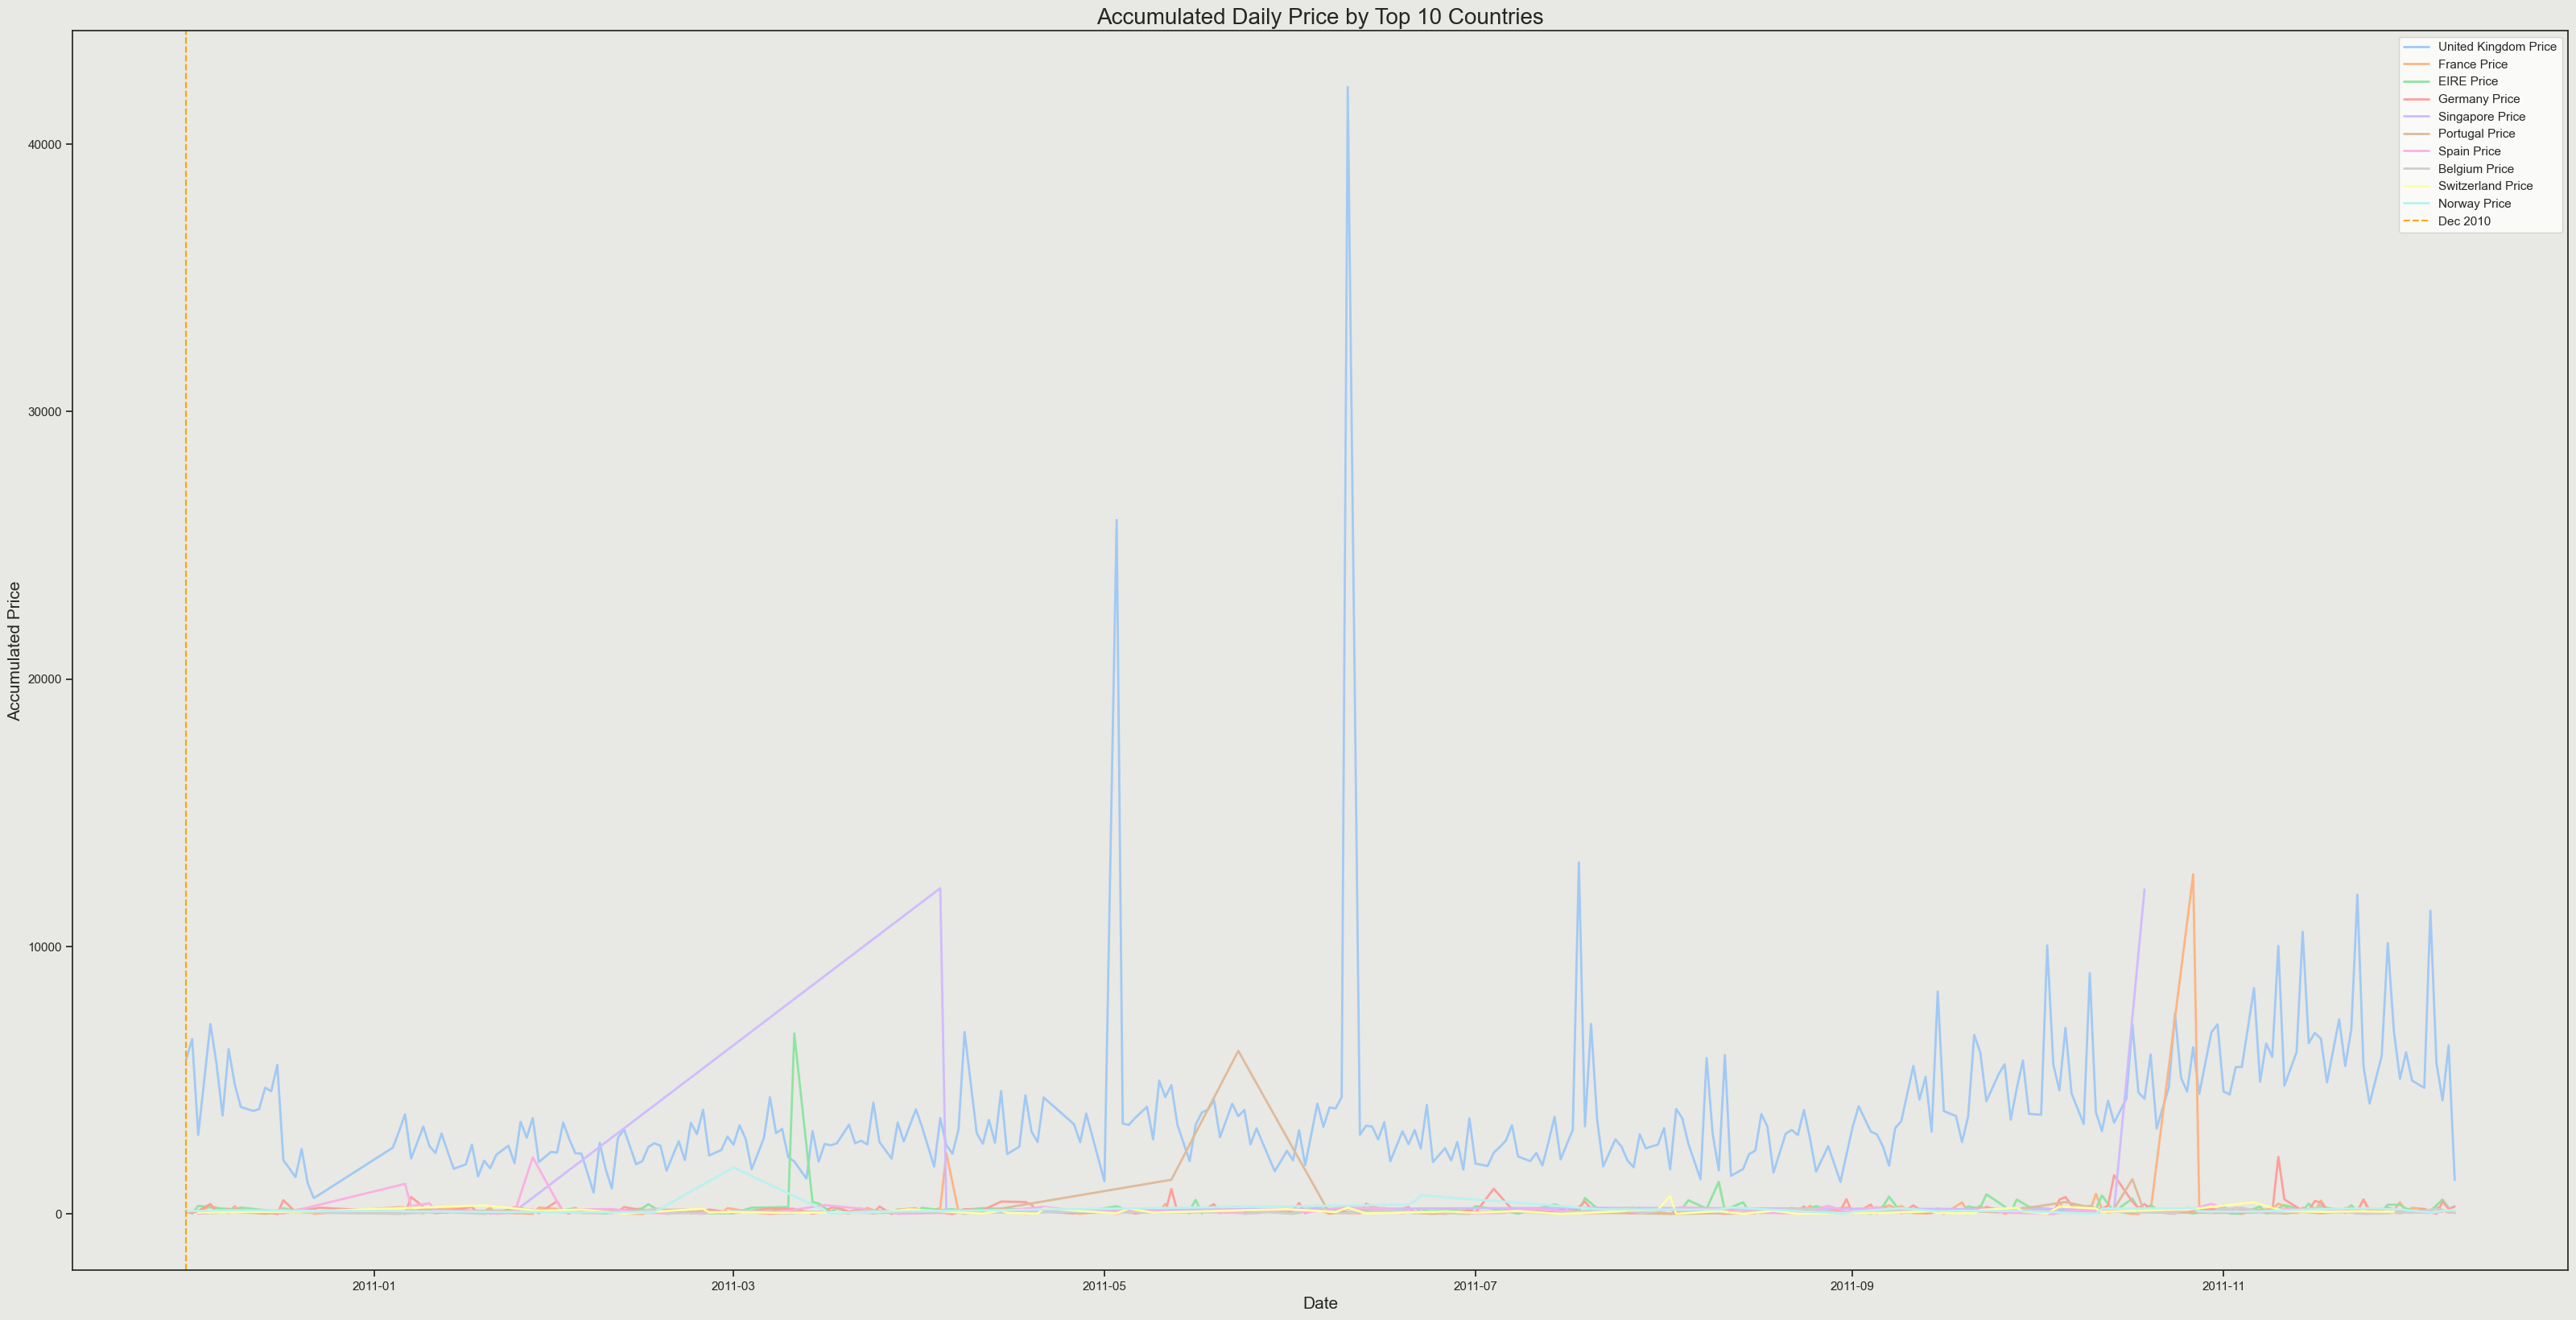

In [45]:
top_countries = (nuevo.groupby('Country')['UnitPrice']
                 .sum()
                 .nlargest(10)
                 .index)

plt.figure(figsize=(40, 20))

for country in top_countries:
    country_data = nuevo[nuevo['Country'] == country]
    
    country_plot = country_data.groupby(country_data.index.date).agg({'UnitPrice': 'sum'})
    
    country_plot["UnitPrice"].plot(label=f"{country} Price", linewidth=2)


plt.axvline(x=pd.to_datetime('2010-12'), color='orange', linestyle='--', label='Dec 2010')
plt.title("Accumulated Daily Price by Top 10 Countries", fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Accumulated Price", fontsize=15)
plt.legend(title="Country", loc="upper left")
plt.gca().set_facecolor('#E8E8E4')  
plt.gcf().set_facecolor('#E8E8E4')
plt.legend(facecolor='#E8E8E4')
plt.legend()
plt.show()
plt.show()

In [46]:
print(len(df))
print(len(df[df.duplicated()]))

406829
5226


In [47]:
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")
df.drop_duplicates(inplace=True)

The dataset contains 5226 duplicate rows that need to be removed.


In [48]:
df[df['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year
InvoiceDate,,,,,,,,,,,,,
2010-12-01 09:41:00,C536379,D,Discount,-1,27.50,14527.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 09:49:00,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 10:24:00,C536391,22553,PLASTERS IN TIN SKULLS,-24,1.65,17548.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 10:24:00,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,3.45,17548.0,United Kingdom,2010,12,1,2,335,48
2010-12-01 10:24:00,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,0.29,17548.0,United Kingdom,2010,12,1,2,335,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-09 09:57:00,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,0.83,14397.0,United Kingdom,2011,12,9,4,343,49
2011-12-09 10:28:00,C581499,M,Manual,-1,224.69,15498.0,United Kingdom,2011,12,9,4,343,49
2011-12-09 11:57:00,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,15311.0,United Kingdom,2011,12,9,4,343,49


In [49]:
df['Transaction_status']= np.where(df['InvoiceNo'].astype(str).str.startswith('C'),'Cancelled','Complete')

In [50]:
df[df['Quantity']>0]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year,Transaction_status
InvoiceDate,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010,12,1,2,335,48,Complete
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48,Complete
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010,12,1,2,335,48,Complete
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48,Complete
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48,Complete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-09 12:50:00,581587,22555,PLASTERS IN TIN STRONGMAN,12,1.65,12680.0,France,2011,12,9,4,343,49,Complete
2011-12-09 12:50:00,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,1.65,12680.0,France,2011,12,9,4,343,49,Complete
2011-12-09 12:50:00,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680.0,France,2011,12,9,4,343,49,Complete


In [51]:
print(len(df))
print(len(df[df['Quantity']>0]))
print(len(df[df['Quantity']<0]))

401603
392731
8872


In [52]:
cancelled= df[df['Transaction_status']=='Cancelled']
percentage_cancelled= (cancelled.shape[0]/df.shape[0])*100

In [53]:
print(f"The percentage of transactions cancelled in the dataset is: {percentage_cancelled}")

The percentage of transactions cancelled in the dataset is: 2.2091468440225794


In [54]:
unique_stock_codes = df['StockCode'].unique()
total=pd.Series(unique_stock_codes)
print(total)

0       85123A
1        71053
2       84406B
3       84029G
4       84029E
         ...  
3679    90214W
3680    90214Z
3681    90214T
3682     90089
3683     23843
Length: 3684, dtype: object


In [55]:
anomlies_code= pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

In [56]:
print(anomlies_code)

5    3676
0       7
1       1
Name: count, dtype: int64


In [57]:
df=df[df['UnitPrice']>0]

In [58]:
# df.reset_index(drop=True,inplace=True)

In [59]:
print(len(df))

401563


In [60]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

In [61]:
df= df[~df['Description'].isin(service_related_descriptions)]

In [62]:
print(len(df))

401480


In [63]:
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

In [64]:
df= df[~df['StockCode'].isin(anomalous_stock_codes)]

In [65]:
print(len(df))

399572


In [66]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year,Transaction_status
InvoiceDate,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010,12,1,2,335,48,Complete
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48,Complete


In [67]:
df['Date']= df.index.date

In [68]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year,Transaction_status,Date
InvoiceDate,,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010,12,1,2,335,48,Complete,2010-12-01
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48,Complete,2010-12-01


In [69]:
customer_data=df.groupby('CustomerID')['Date'].max().reset_index()
most_recent_data= df['Date'].max()
customer_data['Date']= pd.to_datetime(customer_data['Date'])
most_recent_data= pd.to_datetime(most_recent_data)

In [70]:
customer_data['last_date_transaction']=(most_recent_data-customer_data['Date']).dt.days
customer_data.drop(columns='Date',inplace=True)

In [71]:
total_transactions= df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo':'Total_transactions'},inplace=True)

In [72]:
total_products_purchased= df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity':'Total_products_porchased'},inplace=True)

In [73]:
customer_data= pd.merge(customer_data,total_transactions,on="CustomerID")
customer_data= pd.merge(customer_data,total_products_purchased,on="CustomerID")
customer_data.head(2)

,CustomerID,last_date_transaction,Total_transactions,Total_products_porchased
0,12346.0,325,2,0
1,12347.0,2,7,2458


In [74]:
df['total_spend']= df['UnitPrice']*df['Quantity']

In [75]:
total_spend= df.groupby('CustomerID')['total_spend'].sum().reset_index()

In [76]:
average_transaction_value= total_spend.merge(total_transactions,on="CustomerID")
average_transaction_value['Average_transaction_value']= average_transaction_value["total_spend"] / average_transaction_value['Total_transactions']

In [77]:
customer_data= pd.merge(customer_data,total_spend,on='CustomerID')
customer_data= pd.merge(customer_data,average_transaction_value[['CustomerID','Average_transaction_value']],on="CustomerID")
customer_data.head()

,CustomerID,last_date_transaction,Total_transactions,Total_products_porchased,total_spend,Average_transaction_value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


In [78]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year,Transaction_status,Date,total_spend
InvoiceDate,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010,12,1,2,335,48,Complete,2010-12-01,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48,Complete,2010-12-01,20.34


In [79]:
unique_products_purchased= df.groupby('CustomerID')['StockCode'].nunique().reset_index()

In [80]:
unique_products_purchased.rename(columns={'StockCode':'Unique_products_purchased'},inplace=True)
unique_products_purchased.head(2)

,CustomerID,Unique_products_purchased
0,12346.0,1
1,12347.0,103


In [81]:
customer_data= pd.merge(customer_data,unique_products_purchased,on='CustomerID')

In [82]:
df['Hour']= df.index.hour

In [83]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year,Transaction_status,Date,total_spend,Hour
InvoiceDate,,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010,12,1,2,335,48,Complete,2010-12-01,15.30,8
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48,Complete,2010-12-01,20.34,8


In [84]:
days_between_purchases = df.groupby('CustomerID')['Date'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'Date': 'Average_Days_Between_Purchases'}, inplace=True)

favorite_shopping_day= df.groupby(['CustomerID','day_of_week']).size().reset_index(name='Count')
favorite_shopping_day= favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID','day_of_week']]

favorite_shopping_hour= df.groupby(['CustomerID','Hour']).size().reset_index(name='Count')
favorite_shopping_hour= favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID','Hour']]

customer_data= pd.merge(customer_data,average_days_between_purchases,on='CustomerID')
customer_data= pd.merge(customer_data,favorite_shopping_day,on='CustomerID')
customer_data= pd.merge(customer_data,favorite_shopping_hour,on='CustomerID')

customer_data.head()

,CustomerID,last_date_transaction,Total_transactions,Total_products_porchased,total_spend,Average_transaction_value,Unique_products_purchased,Average_Days_Between_Purchases,day_of_week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


In [85]:
customer_country= df.groupby(['CustomerID','Country']).size().reset_index(name='Number_of_transactions')

In [86]:
customer_main_country= customer_country.sort_values('Number_of_transactions',ascending=False).drop_duplicates('CustomerID')
customer_main_country

,CustomerID,Country,Number_of_transactions
4041,17841.0,United Kingdom,7800
1899,14911.0,EIRE,5806
1304,14096.0,United Kingdom,5095
336,12748.0,United Kingdom,4440
1678,14606.0,United Kingdom,2755
...,...,...,...
2527,15753.0,United Kingdom,1
647,13185.0,United Kingdom,1
650,13188.0,United Kingdom,1
1117,13841.0,United Kingdom,1


In [87]:
customer_main_country['uk']= customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

In [88]:
customer_data = pd.merge(customer_data,customer_main_country[['CustomerID','uk']],on='CustomerID',how='left')

In [89]:
total_transactions= df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

cancelled_transactions= df[df['Transaction_status']=='Cancelled']
cancelled_frequency= cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancelled_frequency.rename(columns={'InvoiceNo':'Cancelled_frequency'},inplace=True)


customer_data= pd.merge(customer_data,cancelled_frequency, on='CustomerID',how='left')


customer_data['Cancelled_frequency'].fillna(0,inplace=True)

customer_data['cancelation_rate']= customer_data['Cancelled_frequency']/total_transactions['InvoiceNo']

In [90]:
customer_data.head()

,CustomerID,last_date_transaction,Total_transactions,Total_products_porchased,total_spend,Average_transaction_value,Unique_products_purchased,Average_Days_Between_Purchases,day_of_week,Hour,uk,Cancelled_frequency,cancelation_rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


In [91]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year,Transaction_status,Date,total_spend,Hour
InvoiceDate,,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010,12,1,2,335,48,Complete,2010-12-01,15.30,8
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010,12,1,2,335,48,Complete,2010-12-01,20.34,8


In [92]:
monthly_spend= df.groupby(['CustomerID','year','month'])['total_spend'].sum().reset_index()
monthly_spend

,CustomerID,year,month,total_spend
0,12346.0,2011,1,0.00
1,12347.0,2010,12,711.79
2,12347.0,2011,1,475.39
3,12347.0,2011,4,636.25
4,12347.0,2011,6,382.52
...,...,...,...,...
13616,18283.0,2011,10,112.99
13617,18283.0,2011,11,637.71
13618,18283.0,2011,12,208.00
13619,18287.0,2011,5,765.28


In [93]:
seasonal_pattern= monthly_spend.groupby('CustomerID')['total_spend'].agg(['mean','std']).reset_index()
seasonal_pattern.rename(columns={'mean':'monthly_total_mean','std':'monthly_total_std'},inplace=True)


In [94]:
seasonal_pattern

,CustomerID,monthly_total_mean,monthly_total_std
0,12346.0,0.000000,NaN
1,12347.0,615.714286,341.070789
2,12348.0,359.310000,203.875689
3,12349.0,1457.550000,NaN
4,12350.0,294.400000,NaN
...,...,...,...
4357,18280.0,180.600000,NaN
4358,18281.0,80.820000,NaN
4359,18282.0,88.300000,14.792674
4360,18283.0,203.958000,165.798738


In [95]:
seasonal_pattern['monthly_total_std'].fillna(0,inplace=True)

In [96]:
seasonal_pattern.head(10)

,CustomerID,monthly_total_mean,monthly_total_std
0,12346.0,0.000000,0.000000
1,12347.0,615.714286,341.070789
2,12348.0,359.310000,203.875689
3,12349.0,1457.550000,0.000000
4,12350.0,294.400000,0.000000
5,12352.0,316.352500,134.700629
6,12353.0,89.000000,0.000000
7,12354.0,1079.400000,0.000000
8,12355.0,459.400000,0.000000
9,12356.0,829.143333,991.462585


In [97]:
import numpy as np

In [98]:
from scipy.stats import linregress

In [99]:
def calculate_slope(spend_data):
    if len(spend_data) > 1:
        x= np.arange(len(spend_data))
        slope,_,_,_,_= linregress(x,spend_data)
        return slope
    else:
        return 0

In [100]:
data_with_slope= monthly_spend.groupby('CustomerID')['total_spend'].apply(calculate_slope).reset_index()
data_with_slope.rename(columns={'total_spend':'spending_trend'},inplace=True)

In [101]:
customer_data= pd.merge(customer_data,seasonal_pattern,on='CustomerID')
customer_data= pd.merge(customer_data,data_with_slope,on='CustomerID')

customer_data.head(10)

,CustomerID,last_date_transaction,Total_transactions,Total_products_porchased,total_spend,Average_transaction_value,Unique_products_purchased,Average_Days_Between_Purchases,day_of_week,Hour,uk,Cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.500,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.000,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.000,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.000,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.000,294.400000,0.000000,0.000000
5,12352.0,36,8,463,1265.41,158.176250,57,3.132530,1,14,0,1.0,0.125,316.352500,134.700629,9.351000
6,12353.0,204,1,20,89.00,89.000000,4,0.000000,3,17,0,0.0,0.000,89.000000,0.000000,0.000000
7,12354.0,232,1,530,1079.40,1079.400000,58,0.000000,3,13,0,0.0,0.000,1079.400000,0.000000,0.000000
8,12355.0,214,1,240,459.40,459.400000,13,0.000000,0,13,0,0.0,0.000,459.400000,0.000000,0.000000
9,12356.0,22,3,1573,2487.43,829.143333,52,5.315789,1,9,0,0.0,0.000,829.143333,991.462585,-944.635000


In [102]:
def lowering_columns(df:pd.DataFrame)->pd.DataFrame:
    df.columns= df.columns.str.lower()
    return df

In [103]:
total_data= lowering_columns(customer_data)

In [104]:
total_data.head(10)

,customerid,last_date_transaction,total_transactions,total_products_porchased,total_spend,average_transaction_value,unique_products_purchased,average_days_between_purchases,day_of_week,hour,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.500,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.000,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.000,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.000,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.000,294.400000,0.000000,0.000000
5,12352.0,36,8,463,1265.41,158.176250,57,3.132530,1,14,0,1.0,0.125,316.352500,134.700629,9.351000
6,12353.0,204,1,20,89.00,89.000000,4,0.000000,3,17,0,0.0,0.000,89.000000,0.000000,0.000000
7,12354.0,232,1,530,1079.40,1079.400000,58,0.000000,3,13,0,0.0,0.000,1079.400000,0.000000,0.000000
8,12355.0,214,1,240,459.40,459.400000,13,0.000000,0,13,0,0.0,0.000,459.400000,0.000000,0.000000
9,12356.0,22,3,1573,2487.43,829.143333,52,5.315789,1,9,0,0.0,0.000,829.143333,991.462585,-944.635000


In [105]:
total_data['customerid']= total_data['customerid'].astype(str)
total_data= total_data.convert_dtypes()

In [106]:
total_data.head(20)

,customerid,last_date_transaction,total_transactions,total_products_porchased,total_spend,average_transaction_value,unique_products_purchased,average_days_between_purchases,day_of_week,hour,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0
5,12352.0,36,8,463,1265.41,158.17625,57,3.13253,1,14,0,1,0.125,316.3525,134.700629,9.351
6,12353.0,204,1,20,89.0,89.0,4,0.0,3,17,0,0,0.0,89.0,0.0,0.0
7,12354.0,232,1,530,1079.4,1079.4,58,0.0,3,13,0,0,0.0,1079.4,0.0,0.0
8,12355.0,214,1,240,459.4,459.4,13,0.0,0,13,0,0,0.0,459.4,0.0,0.0
9,12356.0,22,3,1573,2487.43,829.143333,52,5.315789,1,9,0,0,0.0,829.143333,991.462585,-944.635


In [107]:
total_data.iloc[2]

customerid                           12348.0
last_date_transaction                     75
total_transactions                         4
total_products_porchased                2332
total_spend                          1437.24
average_transaction_value             359.31
unique_products_purchased                 21
average_days_between_purchases     10.884615
day_of_week                                3
hour                                      19
uk                                         0
cancelled_frequency                        0
cancelation_rate                         0.0
monthly_total_mean                    359.31
monthly_total_std                 203.875689
spending_trend                      -100.884
Name: 2, dtype: object

- Case Study

In [108]:
record_user=df[df['CustomerID']==12348].drop_duplicates()

In [109]:
record_user.head(2)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month,day,day_of_week,day_of_year,week_of_year,Transaction_status,Date,total_spend,Hour
InvoiceDate,,,,,,,,,,,,,,,,,
2010-12-16 19:09:00,539318,21211,SET OF 72 SKULL PAPER DOILIES,72,1.45,12348.0,Finland,2010,12,16,3,350,50,Complete,2010-12-16,104.4,19
2010-12-16 19:09:00,539318,21977,PACK OF 60 PINK PAISLEY CAKE CASES,120,0.42,12348.0,Finland,2010,12,16,3,350,50,Complete,2010-12-16,50.4,19


In [110]:
record_user.groupby(record_user.index.date).agg({'UnitPrice':'sum'}).reset_index()

,index,UnitPrice
0,2010-12-16,9.60
1,2011-01-25,2.01
2,2011-04-05,4.60
3,2011-09-25,2.50


In [111]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customerid                      4282 non-null   string 
 1   last_date_transaction           4282 non-null   Int64  
 2   total_transactions              4282 non-null   Int64  
 3   total_products_porchased        4282 non-null   Int64  
 4   total_spend                     4282 non-null   Float64
 5   average_transaction_value       4282 non-null   Float64
 6   unique_products_purchased       4282 non-null   Int64  
 7   average_days_between_purchases  4282 non-null   Float64
 8   day_of_week                     4282 non-null   Int32  
 9   hour                            4282 non-null   Int32  
 10  uk                              4282 non-null   Int64  
 11  cancelled_frequency             4282 non-null   Int64  
 12  cancelation_rate                42

In [112]:
total_data.head(5)

,customerid,last_date_transaction,total_transactions,total_products_porchased,total_spend,average_transaction_value,unique_products_purchased,average_days_between_purchases,day_of_week,hour,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0


In [113]:
from sklearn.ensemble import IsolationForest
model= IsolationForest(contamination=0.05,random_state=42)
total_data['outlier_score']= model.fit_predict(total_data.iloc[:,1:].to_numpy())
total_data.head()

,customerid,last_date_transaction,total_transactions,total_products_porchased,total_spend,average_transaction_value,unique_products_purchased,average_days_between_purchases,day_of_week,hour,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend,outlier_score
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1


In [114]:
total_data['is_outlier']= [1 if x == -1 else 0 for x in total_data['outlier_score']]
total_data.head(2)

,customerid,last_date_transaction,total_transactions,total_products_porchased,total_spend,average_transaction_value,unique_products_purchased,average_days_between_purchases,day_of_week,hour,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend,outlier_score,is_outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0


In [115]:
total_data['is_outlier'].value_counts(normalize=True)*100

is_outlier
0    94.978982
1     5.021018
Name: proportion, dtype: float64

In [116]:
total_data_cleaned= total_data[total_data['is_outlier']==0]

In [117]:
total_data_cleaned= total_data_cleaned.drop(columns=['is_outlier','outlier_score'])
total_data_cleaned.reset_index(drop=True,inplace=True)
total_data_cleaned.shape[0]

4067

In [118]:
from matplotlib.colors import LinearSegmentedColormap

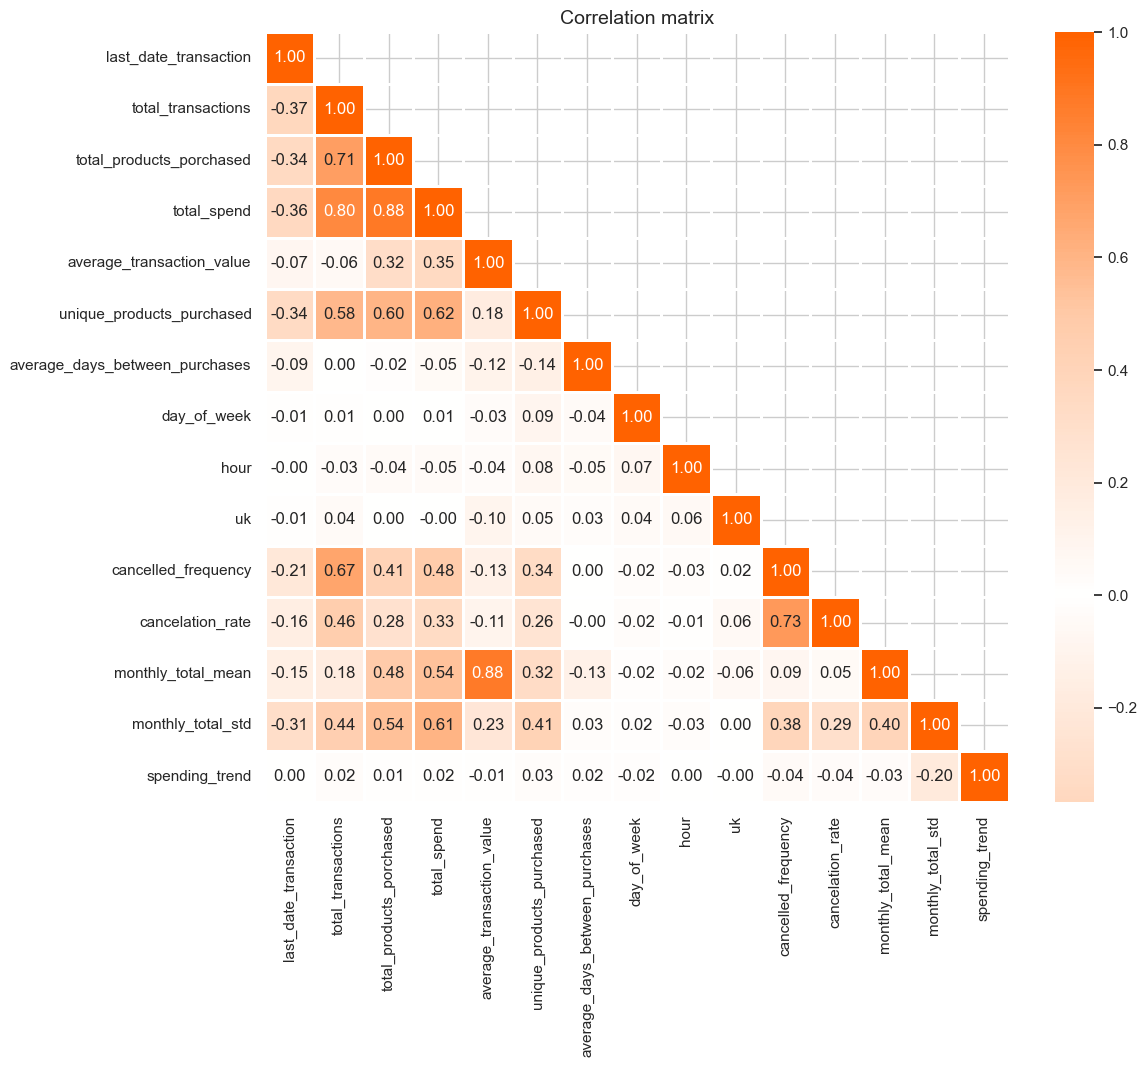

In [123]:
sns.set_style('whitegrid')

coor= total_data_cleaned.drop(columns='customerid').corr()

colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']

my_corr_map = LinearSegmentedColormap.from_list('custom_map',colors,N=256)

mask= np.zeros_like(coor)

mask[np.triu_indices_from(mask,k=1)] = True
plt.figure(figsize=(12,10))
sns.heatmap(coor,mask=mask,cmap=my_corr_map, annot=True, center=0,fmt='.2f',linewidths=2)
plt.title('Correlation matrix',fontsize=14)
plt.show()

In [124]:
total_data_cleaned.head()

,customerid,last_date_transaction,total_transactions,total_products_porchased,total_spend,average_transaction_value,unique_products_purchased,average_days_between_purchases,day_of_week,hour,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0


In [125]:
scaler= StandardScaler()
columns_to_exclude= ['customerid','uk','day_of_week']
columns_to_scale=total_data_cleaned.columns.difference(columns_to_exclude)
customer_data_scaled= total_data_cleaned.copy()
customer_data_scaled[columns_to_scale]= scaler.fit_transform(customer_data_scaled[columns_to_scale])
customer_data_scaled.head(10)

,customerid,last_date_transaction,total_transactions,total_products_porchased,total_spend,average_transaction_value,unique_products_purchased,average_days_between_purchases,day_of_week,hour,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend
0,12346.0,2.350329,-0.470250,-0.786144,-0.829824,-1.326493,-0.889092,-0.336044,1,-1.093494,1,0.360314,0.371881,-1.346779,-0.724928,0.092604
1,12347.0,-0.901915,0.649353,2.108572,2.413080,1.564977,0.768544,-0.132491,1,0.642861,0,-0.525122,-0.422529,1.018951,1.304784,0.118692
2,12348.0,-0.166888,-0.022409,1.960185,0.251575,0.360871,-0.564066,0.762651,3,2.813304,0,-0.525122,-0.422529,0.033781,0.488336,-0.494076
3,12349.0,-0.740813,-0.694170,-0.044211,0.266857,5.518340,0.264753,-0.336044,0,-1.527582,0,-0.525122,-0.422529,4.253498,-0.724928,0.092604
4,12350.0,2.199296,-0.694170,-0.555320,-0.608314,0.056045,-0.645322,-0.336044,2,1.511038,0,-0.525122,-0.422529,-0.215620,-0.724928,0.092604
5,12352.0,-0.559574,0.873273,-0.240882,0.122288,-0.583678,0.020982,-0.019846,1,0.642861,0,0.360314,-0.223927,-0.131273,0.076676,0.146983
6,12353.0,1.131996,-0.694170,-0.762590,-0.762860,-0.908538,-0.840338,-0.336044,3,1.945127,0,-0.525122,-0.422529,-1.004819,-0.724928,0.092604
7,12354.0,1.413924,-0.694170,-0.161978,-0.017669,3.742502,0.037234,-0.336044,3,0.208772,0,-0.525122,-0.422529,2.800550,-0.724928,0.092604
8,12355.0,1.232685,-0.694170,-0.503503,-0.484165,0.830906,-0.694076,-0.336044,0,0.208772,0,-0.525122,-0.422529,0.418352,-0.724928,0.092604
9,12358.0,-0.911984,-0.470250,-0.501147,-0.131539,0.852649,-0.710328,0.603961,1,-1.093494,0,-0.525122,-0.422529,0.436142,-0.226954,0.780796


In [127]:
customer_data_scaled.set_index('customerid', inplace=True)
customer_data_scaled.head()

,last_date_transaction,total_transactions,total_products_porchased,total_spend,average_transaction_value,unique_products_purchased,average_days_between_purchases,day_of_week,hour,uk,cancelled_frequency,cancelation_rate,monthly_total_mean,monthly_total_std,spending_trend
customerid,,,,,,,,,,,,,,,
12346.0,2.350329,-0.470250,-0.786144,-0.829824,-1.326493,-0.889092,-0.336044,1,-1.093494,1,0.360314,0.371881,-1.346779,-0.724928,0.092604
12347.0,-0.901915,0.649353,2.108572,2.413080,1.564977,0.768544,-0.132491,1,0.642861,0,-0.525122,-0.422529,1.018951,1.304784,0.118692
12348.0,-0.166888,-0.022409,1.960185,0.251575,0.360871,-0.564066,0.762651,3,2.813304,0,-0.525122,-0.422529,0.033781,0.488336,-0.494076
12349.0,-0.740813,-0.694170,-0.044211,0.266857,5.518340,0.264753,-0.336044,0,-1.527582,0,-0.525122,-0.422529,4.253498,-0.724928,0.092604
12350.0,2.199296,-0.694170,-0.555320,-0.608314,0.056045,-0.645322,-0.336044,2,1.511038,0,-0.525122,-0.422529,-0.215620,-0.724928,0.092604


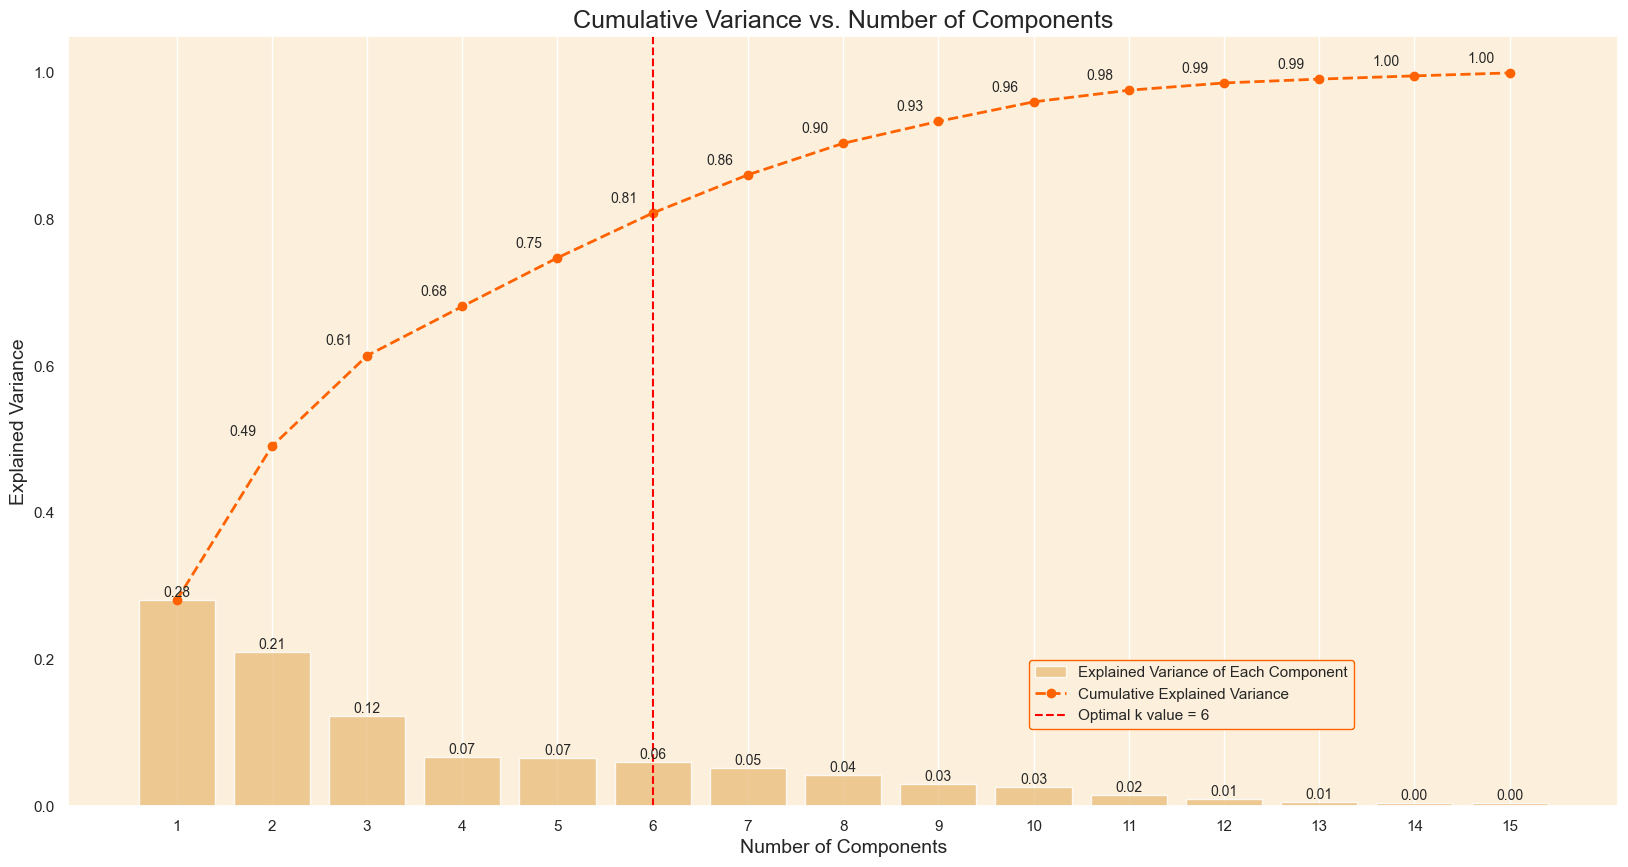

In [ ]:
pca =PCA().fit(customer_data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

optimal_k=6

sns.set(rc={'axes.facecolor':'#fcf0dc'},style='darkgrid')

plt.figure(figsize=(20,10))

barplot= sns.barplot(x=list(range(1,len(cumulative_explained_variance)+1)),
                     y=explained_variance_ratio,
                     color='#fcc36d',
                     alpha=0.8)

lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()